# Analysis of multiple URANOS scenarios at once

The is an example script to read and plot multiple URANOS output files (neutron density maps) of the same scenario with different parameters (e.g., varying soil moisture).

*-- last modified: June 29, 2022*

In [1]:
# import basic functions from the URANOS library
from lib.uranos import collect_results, barplot_results

## Define the scenario
Provide the parameters that have changed between the different URANOS runs and generate a list of file names that contain the density maps. It is recommended to put all density map CSV files of a certain simulation into one zip file. The provided scripts will automatically add them up.

In [19]:
# Define study parameters (one for each URANOS simulation)
# Here: soil moisture has been set to 2/15/50% in 3 URANOS simulations.
range_of_soil_moisture = 2, 15, 50

In [20]:
# For each parameter, assign the densityMap file (or a zip that contains them)
files = []
for sm in range_of_soil_moisture:
    file = 'example_uranos_output/homogen-sm{:02d}.zip'.format(sm)
    files.append(file)
files

['example_uranos_output/homogen-sm02.zip',
 'example_uranos_output/homogen-sm15.zip',
 'example_uranos_output/homogen-sm50.zip']

## Read and sum up density matrices
Use function `collect_results(files, ...) -> list of arrays` with options:
- `files` - list of file names (zip or csv)
- `size=500` - size of the URANOS output matrices, 500 by default
- `norm_id=0` - Use `norm_id=n` to normalize the results relative to the $n$th element (or set -1 for no normalization = absolute values)
- `radius=[200,200]` - crop the matrix by the inner 200x200 elements (i.e., ignore the outer 50 pixels to avoid border effects from the simulation. This is not necessary if you used reflective or periodic boundary conditions in URANOS.
- `dropx=0, dropy=0` - Drop x columns from the right or y rows from the bottom of the cropped matrix.
- `repeat_shift=None` - Extract only pixels that are shifted by this number of pixels (e.g., for repeated patterns, extract every 3rd pixel only). This has been used for regular patterns in orchard irrigation by Li et al. 2017.
- `repeat_center` - Define the center of the repeated extraction.

In [4]:
# Read URANOS files into a list of flattened neutron density matrices (=arrays)
neutron_arrays = collect_results(files, norm_id=-1)

Reading file: example_uranos_output/homogen-sm02.zip
Reading file: example_uranos_output/homogen-sm15.zip
Reading file: example_uranos_output/homogen-sm50.zip
Mean values: 29.0, 18.6, 15.0


Conveniently, the function already provides a glimpse on the average neutron counts for each scenario. Looks like neutrons depend on soil moisture... 

In [6]:
# Here is how one of those matrices looks like:
neutron_arrays[0]

array([40., 23., 34., ..., 26., 18., 24.])

Note that `collect_results()` does *not* return a 2D array (or matrix), it returns a 1D flattened array instead. This is sufficient for homogeneous scenarios where spatial patterns don't matter.

## Plot results

You can make your own plots, ofcourse, but the following functions provide a quick shortcut without the need to import matplotlib or care for basic labeling. You may use
- `barplot_results(arrays, ...) -> ax, bars`, or
- `boxplot_results(arrays, ...) -> ax, boxes`

with the following options:

- `data` - list of matrices (plots a bar/box for each matrix)
- `labels=None` - label the x axis ticks of the bars/boxes or just use a, b, c, ...
- `width=0.3` - width of the bars/boxes
- `x_offset=0` - offset along x axis, can be used to put multiple bars/boxes side by side for each scenario
- `ax=None` - Provide an existing axis here to add this plot as a subpanel of an overarching figure, for instance. If no ax is given, a new figure and axis is created and returned. 
- `title` - title of the plot, defaults to "Detector count average"
- `y_label` - y axis label defaults to "Relative neutron counts"
- `y_ticks=None` - y ticks can be set directlly here,
- `color='C0'` - bar color
- `figsize=(7,5)` - figure size
- `text=None` - text to draw on top of the bars

With the returned `ax` object and `bars`/`boxes` patches, you can make additional changes to the axis or patches afterwards, e.g., `ax.set_ylim(0,1)`.

Text(0.5, 0, 'Soil moisture (in %)')

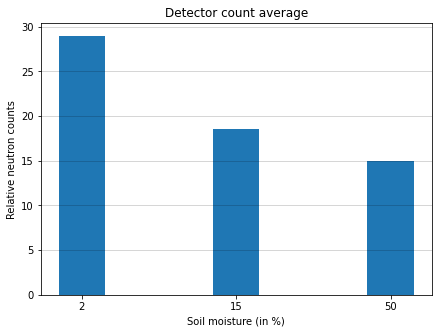

In [7]:
# Plot the results as a bar plot
ax, bars = barplot_results(neutron_arrays, labels=range_of_soil_moisture)
ax.set_xlabel('Soil moisture (in %)')

## Export to DataFrame and CSV
To further process the data, it is often convenient to export the main attributes of the results (i.e., mean and uncertainty) to a DataFrame or as a CSV file.

In [13]:
import os
import pandas
import numpy as np
from scipy.stats import sem

In [17]:
# Create a DataFrame
data = pandas.DataFrame(index = pandas.Series(range_of_soil_moisture, name='sm'))
data['N'] = [np.mean(n) for n in neutron_arrays]
data['N_err'] = [sem(n) for n in neutron_arrays]
data

,N,N_err
sm,,
2,28.965591,0.023247
15,18.575332,0.011748
50,15.025572,0.014328


In [18]:
# Export mean and uncertainty as CSV 
output_file = 'uranos_results.csv'data.to_csv(output_file, float_format='%.4f')
print("< Data saved to '%s' (%.0f KB)" % (output_file, os.stat(output_file).st_size/1024))

< Data saved to 'example_uranos_output/homogen-sm50.zip' (365 KB)
